In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from merf import MERF

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import normaltest
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
data = pd.read_csv('data\evolucaodemanda.csv', sep=';', decimal=',')

# Lista das colunas que devem ser convertidas para int
colunas_int = ['MAT_CRECHE', 'MAT_PRE_ESCOLA', 'MAT_FUND_I', 'MAT_FUND_II',
               'MAT_EJA_I', 'MAT_EJA_II', 'MAT_ENS_MED', 'MAT_ED_PROF',
               'MAT_PROC_CRECHE', 'MAT_PROC_PRE_ESC', 'DEM_CRECHE', 'DEM_PRE',
               'DEM_FUND_I', 'DEM_FUND_II', 'DEM_EJA_I', 'DEM_EJA_II',
               'DEM_PREF_CRECHE', 'DEM_PREF_PRE']

# Converter as colunas para float64 para lidar com valores não numéricos
data[colunas_int] = data[colunas_int].apply(pd.to_numeric, errors='coerce')

# Preencher valores NaN com 0, se necessário
data[colunas_int] = data[colunas_int].fillna(0).astype(int)

In [3]:
# Verificar os tipos de dados do DataFrame resultante
print(data.dtypes)

DISTRITO            object
MAT_CRECHE           int32
MAT_PRE_ESCOLA       int32
MAT_FUND_I           int32
MAT_FUND_II          int32
MAT_EJA_I            int32
MAT_EJA_II           int32
MAT_ENS_MED          int32
MAT_ED_PROF          int32
MAT_PROC_CRECHE      int32
MAT_PROC_PRE_ESC     int32
DEM_CRECHE           int32
DEM_PRE              int32
DEM_FUND_I           int32
DEM_FUND_II          int32
DEM_EJA_I            int32
DEM_EJA_II           int32
DEM_PREF_CRECHE      int32
DEM_PREF_PRE         int32
MES_ANO_REF         object
dtype: object


In [4]:
data.head()

,DISTRITO,MAT_CRECHE,MAT_PRE_ESCOLA,MAT_FUND_I,MAT_FUND_II,MAT_EJA_I,MAT_EJA_II,MAT_ENS_MED,MAT_ED_PROF,MAT_PROC_CRECHE,MAT_PROC_PRE_ESC,DEM_CRECHE,DEM_PRE,DEM_FUND_I,DEM_FUND_II,DEM_EJA_I,DEM_EJA_II,DEM_PREF_CRECHE,DEM_PREF_PRE,MES_ANO_REF
0,AGUA RASA,573,1,1,1,219,137,0,0,0,0,505,153,0,0,0,0,0,0,jun/06
1,ALTO DE PINHEIROS,236,198,0,0,0,0,0,0,0,0,64,2,0,0,0,0,0,0,jun/06
2,ANHANGUERA,207,1,2,2,187,856,0,0,0,0,138,274,0,0,0,0,0,0,jun/06
3,ARICANDUVA,435,1,2,2,187,670,0,0,0,0,523,130,0,0,0,0,0,0,jun/06
4,ARTUR ALVIM,901,4,3,2,201,837,0,0,0,0,670,155,0,0,0,0,0,0,jun/06


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DISTRITO          6528 non-null   object
 1   MAT_CRECHE        6528 non-null   int32 
 2   MAT_PRE_ESCOLA    6528 non-null   int32 
 3   MAT_FUND_I        6528 non-null   int32 
 4   MAT_FUND_II       6528 non-null   int32 
 5   MAT_EJA_I         6528 non-null   int32 
 6   MAT_EJA_II        6528 non-null   int32 
 7   MAT_ENS_MED       6528 non-null   int32 
 8   MAT_ED_PROF       6528 non-null   int32 
 9   MAT_PROC_CRECHE   6528 non-null   int32 
 10  MAT_PROC_PRE_ESC  6528 non-null   int32 
 11  DEM_CRECHE        6528 non-null   int32 
 12  DEM_PRE           6528 non-null   int32 
 13  DEM_FUND_I        6528 non-null   int32 
 14  DEM_FUND_II       6528 non-null   int32 
 15  DEM_EJA_I         6528 non-null   int32 
 16  DEM_EJA_II        6528 non-null   int32 
 17  DEM_PREF_CRECH

In [8]:
data.columns

Index(['DISTRITO', 'MAT_CRECHE', 'MAT_PRE_ESCOLA', 'MAT_FUND_I', 'MAT_FUND_II',
       'MAT_EJA_I', 'MAT_EJA_II', 'MAT_ENS_MED', 'MAT_ED_PROF',
       'MAT_PROC_CRECHE', 'MAT_PROC_PRE_ESC', 'DEM_CRECHE', 'DEM_PRE',
       'DEM_FUND_I', 'DEM_FUND_II', 'DEM_EJA_I', 'DEM_EJA_II',
       'DEM_PREF_CRECHE', 'DEM_PREF_PRE', 'MES_ANO_REF'],
      dtype='object')

In [9]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DISTRITO,6528,96,AGUA RASA,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAT_CRECHE,6528.0,NaN,NaN,NaN,458.918199,1279.575592,0.0,2.0,7.0,484.0,15540.0
MAT_PRE_ESCOLA,6528.0,NaN,NaN,NaN,366.135263,907.981348,0.0,2.0,5.0,507.25,11144.0
MAT_FUND_I,6528.0,NaN,NaN,NaN,351.008885,982.363062,0.0,2.0,4.0,371.25,11954.0
MAT_FUND_II,6528.0,NaN,NaN,NaN,296.356311,766.365142,0.0,1.0,4.0,328.5,9003.0
MAT_EJA_I,6528.0,NaN,NaN,NaN,120.596048,158.702627,0.0,0.0,63.0,179.25,986.0
MAT_EJA_II,6528.0,NaN,NaN,NaN,249.023591,287.578447,0.0,1.0,139.5,428.0,2383.0
MAT_ENS_MED,6528.0,NaN,NaN,NaN,24.000613,101.97558,0.0,0.0,0.0,0.0,999.0
MAT_ED_PROF,6528.0,NaN,NaN,NaN,5.208793,57.395665,0.0,0.0,0.0,0.0,1492.0
MAT_PROC_CRECHE,6528.0,NaN,NaN,NaN,18.515012,56.295689,0.0,0.0,3.0,14.0,1110.0


In [6]:
data[['MES','ANO']] = data['MES_ANO_REF'].str.split('/', 1, expand=True)
data['ANO'] = '20' + data['ANO'].apply(lambda x: x.strip())

C:\Users\letic\AppData\Local\Temp\ipykernel_17076\4218350511.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data[['MES','ANO']] = data['MES_ANO_REF'].str.split('/', 1, expand=True)


In [7]:
data.head()

,DISTRITO,MAT_CRECHE,MAT_PRE_ESCOLA,MAT_FUND_I,MAT_FUND_II,MAT_EJA_I,MAT_EJA_II,MAT_ENS_MED,MAT_ED_PROF,MAT_PROC_CRECHE,...,DEM_PRE,DEM_FUND_I,DEM_FUND_II,DEM_EJA_I,DEM_EJA_II,DEM_PREF_CRECHE,DEM_PREF_PRE,MES_ANO_REF,MES,ANO
0,AGUA RASA,573,1,1,1,219,137,0,0,0,...,153,0,0,0,0,0,0,jun/06,jun,2006
1,ALTO DE PINHEIROS,236,198,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,jun/06,jun,2006
2,ANHANGUERA,207,1,2,2,187,856,0,0,0,...,274,0,0,0,0,0,0,jun/06,jun,2006
3,ARICANDUVA,435,1,2,2,187,670,0,0,0,...,130,0,0,0,0,0,0,jun/06,jun,2006
4,ARTUR ALVIM,901,4,3,2,201,837,0,0,0,...,155,0,0,0,0,0,0,jun/06,jun,2006


In [9]:
data['MES_NUM'] = pd.to_datetime(data['DATA'], format='%Y-%m').dt.month

In [12]:
data['GAP_CRECHE'] = data['MAT_CRECHE'] - data['DEM_CRECHE']
data['GAP_PRE'] = data['MAT_PRE_ESCOLA'] - data['DEM_PRE']
data['GAP_FUND_I'] = data['MAT_FUND_I'] - data['DEM_FUND_I']

In [74]:
pd.set_option('display.max_columns',100)
data.head()

,DISTRITO,MAT_CRECHE,MAT_PRE_ESCOLA,MAT_FUND_I,MAT_FUND_II,MAT_EJA_I,MAT_EJA_II,MAT_ENS_MED,MAT_ED_PROF,MAT_PROC_CRECHE,MAT_PROC_PRE_ESC,DEM_CRECHE,DEM_PRE,DEM_FUND_I,DEM_FUND_II,DEM_EJA_I,DEM_EJA_II,DEM_PREF_CRECHE,DEM_PREF_PRE,MES_ANO_REF,MES,ANO,DATA
0,AGUA RASA,573,1,1,1,219,137,0,0,0,0,505,153,0,0,0,0,0,0,jun/06,jun,2006,2006-06
1,ALTO DE PINHEIROS,236,198,0,0,0,0,0,0,0,0,64,2,0,0,0,0,0,0,jun/06,jun,2006,2006-06
2,ANHANGUERA,207,1,2,2,187,856,0,0,0,0,138,274,0,0,0,0,0,0,jun/06,jun,2006,2006-06
3,ARICANDUVA,435,1,2,2,187,670,0,0,0,0,523,130,0,0,0,0,0,0,jun/06,jun,2006,2006-06
4,ARTUR ALVIM,901,4,3,2,201,837,0,0,0,0,670,155,0,0,0,0,0,0,jun/06,jun,2006,2006-06


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DISTRITO          6528 non-null   object
 1   MAT_CRECHE        6528 non-null   int32 
 2   MAT_PRE_ESCOLA    6528 non-null   int32 
 3   MAT_FUND_I        6528 non-null   int32 
 4   MAT_FUND_II       6528 non-null   int32 
 5   MAT_EJA_I         6528 non-null   int32 
 6   MAT_EJA_II        6528 non-null   int32 
 7   MAT_ENS_MED       6528 non-null   int32 
 8   MAT_ED_PROF       6528 non-null   int32 
 9   MAT_PROC_CRECHE   6528 non-null   int32 
 10  MAT_PROC_PRE_ESC  6528 non-null   int32 
 11  DEM_CRECHE        6528 non-null   int32 
 12  DEM_PRE           6528 non-null   int32 
 13  DEM_FUND_I        6528 non-null   int32 
 14  DEM_FUND_II       6528 non-null   int32 
 15  DEM_EJA_I         6528 non-null   int32 
 16  DEM_EJA_II        6528 non-null   int32 
 17  DEM_PREF_CRECH

In [15]:
data['DISTRITO'].nunique()

96

In [16]:
data['ANO'].value_counts().sort_index()

2006    288
2007    384
2008    384
2009    384
2010    384
2011    384
2012    384
2013    384
2014    384
2015    384
2016    384
2017    384
2018    288
2019    384
2020    384
2021    384
2022    384
2023    192
Name: ANO, dtype: int64

In [17]:
pd.set_option('display.max_rows', 2000)
agrupamento = data.groupby(['ANO']).sum()
df_ano = agrupamento.reset_index()

C:\Users\letic\AppData\Local\Temp\ipykernel_10064\473593131.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agrupamento = data.groupby(['ANO']).sum()


In [18]:
df_ano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ANO               18 non-null     object
 1   MAT_CRECHE        18 non-null     int32 
 2   MAT_PRE_ESCOLA    18 non-null     int32 
 3   MAT_FUND_I        18 non-null     int32 
 4   MAT_FUND_II       18 non-null     int32 
 5   MAT_EJA_I         18 non-null     int32 
 6   MAT_EJA_II        18 non-null     int32 
 7   MAT_ENS_MED       18 non-null     int32 
 8   MAT_ED_PROF       18 non-null     int32 
 9   MAT_PROC_CRECHE   18 non-null     int32 
 10  MAT_PROC_PRE_ESC  18 non-null     int32 
 11  DEM_CRECHE        18 non-null     int32 
 12  DEM_PRE           18 non-null     int32 
 13  DEM_FUND_I        18 non-null     int32 
 14  DEM_FUND_II       18 non-null     int32 
 15  DEM_EJA_I         18 non-null     int32 
 16  DEM_EJA_II        18 non-null     int32 
 17  DEM_PREF_CRECHE   

In [19]:
df_ano.head()

,ANO,MAT_CRECHE,MAT_PRE_ESCOLA,MAT_FUND_I,MAT_FUND_II,MAT_EJA_I,MAT_EJA_II,MAT_ENS_MED,MAT_ED_PROF,MAT_PROC_CRECHE,MAT_PROC_PRE_ESC,DEM_CRECHE,DEM_PRE,DEM_FUND_I,DEM_FUND_II,DEM_EJA_I,DEM_EJA_II,DEM_PREF_CRECHE,DEM_PREF_PRE,GAP_CRECHE,GAP_PRE,GAP_FUND_I
0,2006,102816,38483,33490,33130,66385,63130,5843,2064,0,0,83858,61808,0,0,0,0,0,0,18958,-23325,33490
1,2007,121447,48446,45910,42268,80448,82920,7137,2913,0,0,110086,94036,0,0,0,0,0,0,11361,-45590,45910
2,2008,105455,43026,47056,42209,73444,87237,7420,2562,2803,4598,96605,73847,0,0,0,0,3482,1513,8850,-30821,47056
3,2009,102335,46929,50833,42852,68830,94315,6793,2384,4104,7016,107628,69985,0,0,0,0,15765,17636,-5293,-23056,50833
4,2010,99455,60562,58021,47394,59579,96518,6931,2236,8589,7565,100710,73939,0,0,0,0,0,0,-1255,-13377,58021


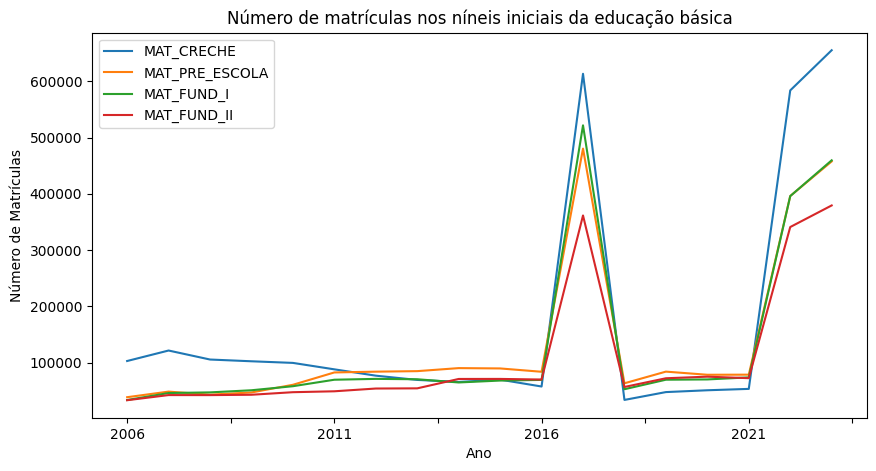

In [22]:
colunas = ['MAT_CRECHE', 'MAT_PRE_ESCOLA', 'MAT_FUND_I', 'MAT_FUND_II']
       
df_ano.plot(figsize=(10,5), x='ANO', y=colunas, kind='line')
plt.xlabel('Ano')
plt.ylabel('Número de Matrículas')
plt.title('Número de matrículas nos níneis iniciais da educação básica')
plt.legend()

In [23]:
df_ano2 = df_ano
df_ano2['ANO'] = pd.to_datetime(df_ano2['ANO'])

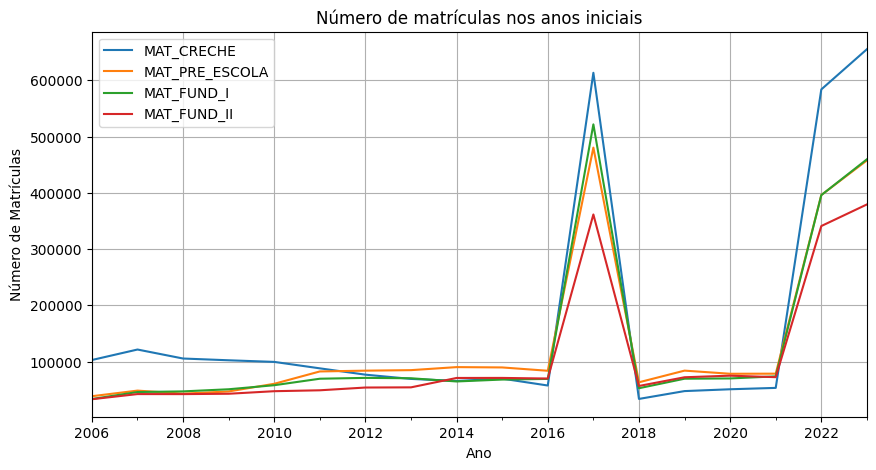

In [24]:
df_ano2.plot(figsize=(10,5), x='ANO', y=colunas, kind='line')
plt.xlabel('Ano')
plt.ylabel('Número de Matrículas')
plt.title('Número de matrículas nos anos iniciais')
#plt.xticks(df_ano2['ANO'], rotation=90)
plt.grid(True)
plt.legend()

In [25]:
dados_agrupados = data.groupby('DISTRITO')['MAT_CRECHE'].sum()
dados_agrupados = dados_agrupados.sort_values(ascending=False)
dados_agrupados

DISTRITO
JARDIM ANGELA         71360
GRAJAU                69351
BRASILANDIA           58271
LAJEADO               57520
JARDIM SAO LUIS       57171
CAPAO REDONDO         55946
CIDADE TIRADENTES     54470
JARAGUA               50928
ITAIM PAULISTA        50432
SACOMA                48593
MOOCA                 47425
SAPOPEMBA             46249
LIBERDADE             44172
CAMPO LIMPO           42970
TATUAPE               41772
BRAS                  40955
BUTANTA               40879
VILA GUILHERME        40335
ITAQUERA              40061
PARELHEIROS           39713
CIDADE ADEMAR         39564
JARDIM HELENA         39086
CAMPO BELO            37999
JAGUARA               37759
VILA MARIANA          36950
TREMEMBE              36818
BOM RETIRO            36792
AGUA RASA             36606
CIDADE DUTRA          35577
VILA SONIA            35101
SAO MATEUS            34816
SAO DOMINGOS          34272
PEDREIRA              34271
PERDIZES              34144
PERUS                 33610
IGUATEMI   

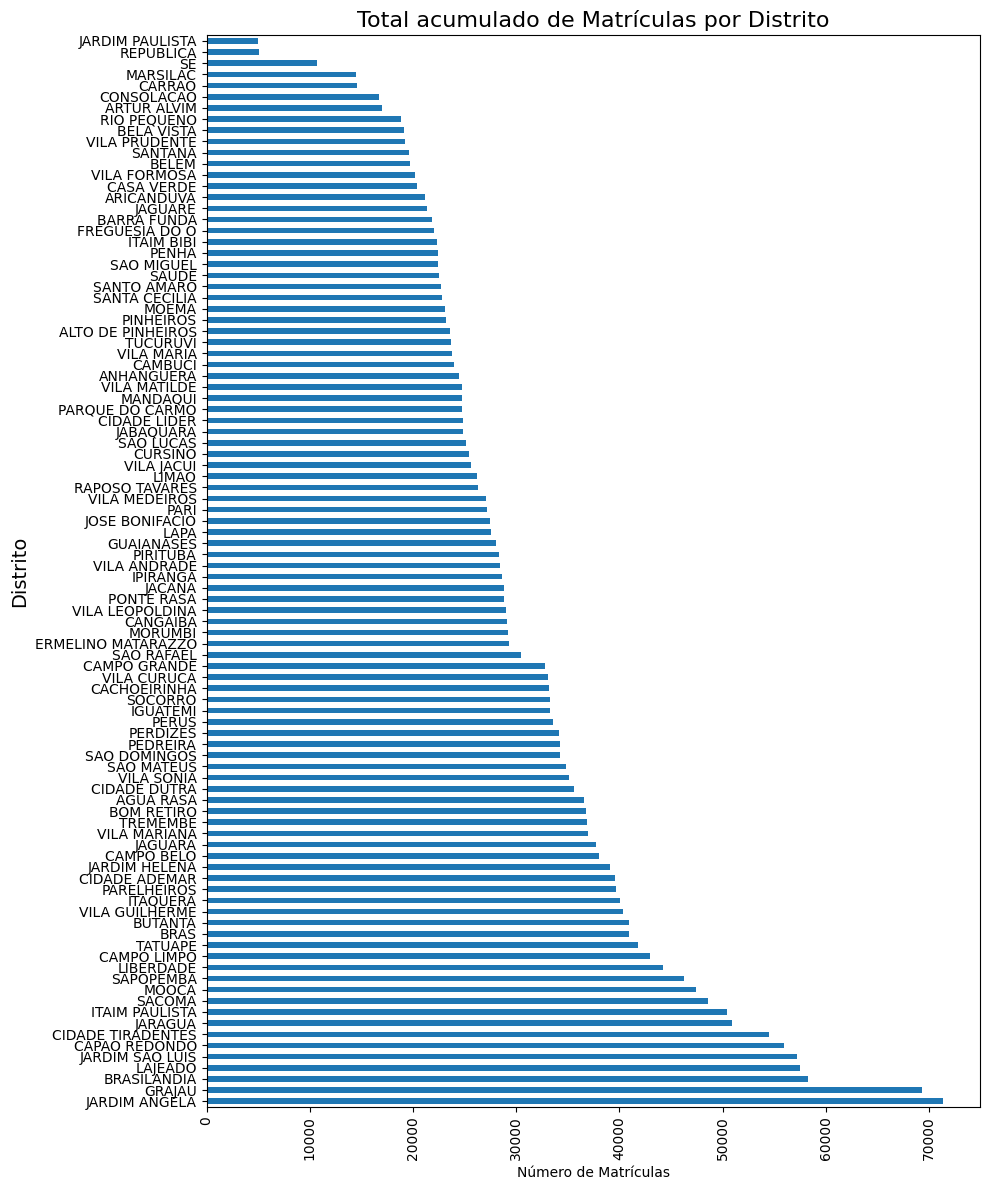

In [55]:
plt.figure(figsize=(10, 12))
dados_agrupados.plot(kind='barh')
plt.title('Total acumulado de Matrículas por Distrito', fontsize=16)
plt.xlabel('Número de Matrículas')
plt.ylabel('Distrito', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

In [26]:
# Soma das matrículas de todos os distritos em cada mês de referência da base de dados
df_mat_creche = data.groupby('DATA')['MAT_CRECHE'].sum().reset_index()
df_mat_creche['DATA'] = pd.to_datetime(df_mat_creche['DATA']).dt.to_period('M')
df_mat_creche['data_first_day'] = pd.to_datetime(df_mat_creche['DATA'].astype(str)) + pd.offsets.MonthBegin(0)
df_mat_creche = df_mat_creche.set_index('data_first_day')

In [27]:
df_mat_creche.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2006-06-01 to 2023-04-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   DATA        68 non-null     period[M]
 1   MAT_CRECHE  68 non-null     int32    
dtypes: int32(1), period[M](1)
memory usage: 1.3 KB


In [28]:
df_mat_creche.head(100)

,DATA,MAT_CRECHE
data_first_day,,
2006-06-01,2006-06,35467
2006-09-01,2006-09,33901
2006-12-01,2006-12,33448
2007-03-01,2007-03,33215
2007-06-01,2007-06,28641
2007-09-01,2007-09,29756
2007-12-01,2007-12,29835
2008-03-01,2008-03,27532
2008-06-01,2008-06,27085


In [29]:
df_mat_creche.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2006-06-01 to 2023-04-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   DATA        68 non-null     period[M]
 1   MAT_CRECHE  68 non-null     int32    
dtypes: int32(1), period[M](1)
memory usage: 1.3 KB


In [30]:
df_mat_creche.isnull().sum()

DATA          0
MAT_CRECHE    0
dtype: int64

In [31]:
# criação do dataframe com a soma das matrículas em cada data de publicação de resultados

pd.set_option('display.max_rows', 2000)
agrup_ano_mes = data.groupby(['DATA']).sum()
df_ano_mes = agrup_ano_mes.reset_index()

C:\Users\letic\AppData\Local\Temp\ipykernel_10064\1791280261.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agrup_ano_mes = data.groupby(['DATA']).sum()


In [32]:
df_ano_mes.head(2)

,DATA,MAT_CRECHE,MAT_PRE_ESCOLA,MAT_FUND_I,MAT_FUND_II,MAT_EJA_I,MAT_EJA_II,MAT_ENS_MED,MAT_ED_PROF,MAT_PROC_CRECHE,MAT_PROC_PRE_ESC,DEM_CRECHE,DEM_PRE,DEM_FUND_I,DEM_FUND_II,DEM_EJA_I,DEM_EJA_II,DEM_PREF_CRECHE,DEM_PREF_PRE,GAP_CRECHE,GAP_PRE,GAP_FUND_I
0,2006-06,35467,14167,11659,12348,24344,20592,2064,700,0,0,30515,21774,0,0,0,0,0,0,4952,-7607,11659
1,2006-09,33901,12208,10622,10042,21292,21727,1951,699,0,0,27569,16641,0,0,0,0,0,0,6332,-4433,10622


In [33]:
# Criação de um dataframe apenas com a coluna de data e a de matrículas nas creches
df_novo = df_ano_mes.loc[:, ['DATA', 'MAT_CRECHE']]

In [34]:
df_novo.head(2)

,DATA,MAT_CRECHE
0,2006-06,35467
1,2006-09,33901


In [35]:
df_novo.set_index('DATA', inplace=True)
df_novo.index=pd.to_datetime(df_novo.index)

In [36]:
df_novo.head()

,MAT_CRECHE
DATA,
2006-06-01,35467
2006-09-01,33901
2006-12-01,33448
2007-03-01,33215
2007-06-01,28641


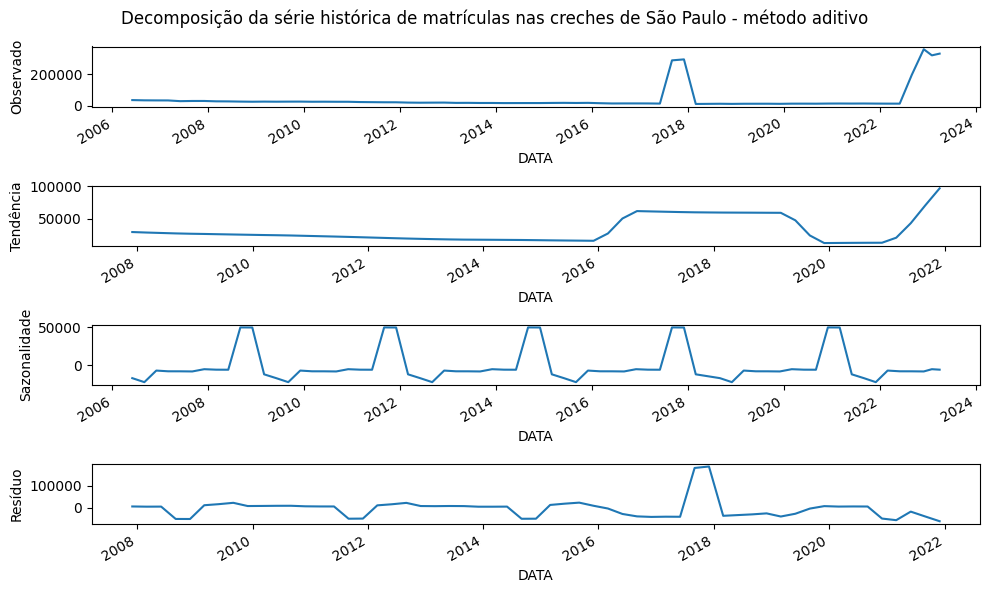

In [57]:
# Decomposição com o método aditivo
result = seasonal_decompose(df_novo['MAT_CRECHE'], model='aditive', period=12)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6))  # Aumenta o tamanho do plot
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observado')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Tendência')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Sazonalidade')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Resíduo')
plt.suptitle('Decomposição da série histórica de matrículas nas creches de São Paulo - método aditivo')
plt.tight_layout()

In [50]:
# Verificar a significância da sazonalidade
is_seasonal_significant = result.seasonal[~np.isnan(result.seasonal)].any()

if is_seasonal_significant:
    print("A sazonalidade é estatisticamente significativa (modelo multiplicativo)")
else:
    print("A sazonalidade não é estatisticamente significativa (modelo aditivo)")


A sazonalidade é estatisticamente significativa (modelo multiplicativo)


In [51]:
# Obter os resíduos da decomposição
residuals = result.resid[~np.isnan(result.resid)]

# Calcular as autocorrelações dos resíduos
acf_resid = acf(residuals)

# Verificar se a variância dos resíduos é constante
is_homogeneous_variance = all(acf_resid < 0.2)

if is_homogeneous_variance:
    print("A variância dos resíduos é constante (modelo aditivo)")
else:
    print("A variância dos resíduos não é constante (modelo multiplicativo)")

A variância dos resíduos não é constante (modelo multiplicativo)


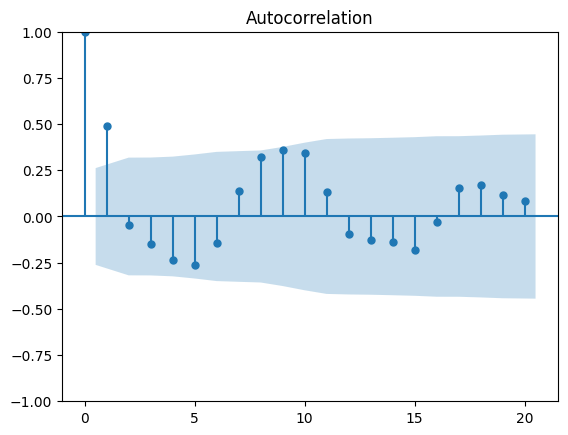

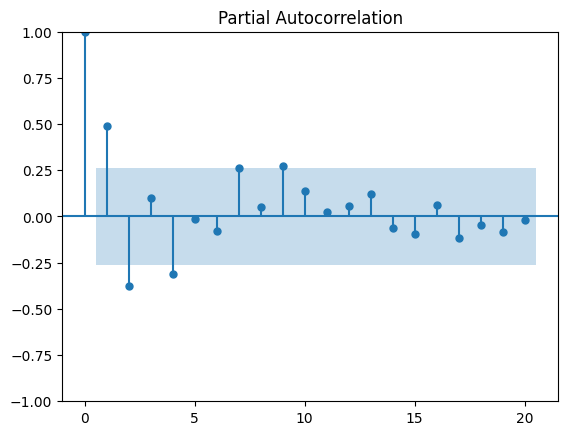

In [53]:
# Plotar o ACF dos resíduos
plot_acf(residuals, lags=20)
plt.show()

# Plotar o PACF dos resíduos
plot_pacf(residuals, lags=20)
plt.show()

In [55]:
# Teste de normalidade nos resíduos
_, p_value = normaltest(residuals)

alpha = 0.05  # Nível de significância

if p_value < alpha:
    print("Os resíduos não seguem uma distribuição normal (modelo aditivo)")
else:
    print("Os resíduos seguem uma distribuição normal (modelo multiplicativo)")


Os resíduos não seguem uma distribuição normal (modelo aditivo)


In [58]:
result = adfuller(df_novo['MAT_CRECHE'])
print('Estatística ADF:', result[0])
print('Valor-p:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t', key, ':', value)

Estatística ADF: -1.7151616610915932
Valor-p: 0.42331814917945315
Valores críticos:
	 1% : -3.53692771987915
	 5% : -2.907887369384766
	 10% : -2.591493291015625


In [70]:
result = kpss(df_novo['MAT_CRECHE'])
print('Estatística KPSS:', result[0])
print('Valor-p:', result[1])
print('Valores críticos:')
for key, value in result[3].items():
    print('\t', key, ':', value)

Estatística KPSS: 0.3441223408438107
Valor-p: 0.1
Valores críticos:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739


C:\Users\letic\AppData\Local\Temp\ipykernel_9864\913510612.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df_novo['MAT_CRECHE'])


# Modelos

### Modelagem aplicados dados sem nenhun tratamento especial

In [71]:
df = data.loc[:,['DATA','MES','ANO','DISTRITO', 'MAT_CRECHE']]

In [72]:
df.head(2)

,DATA,MES,ANO,DISTRITO,MAT_CRECHE
0,2006-06,jun,2006,AGUA RASA,573
1,2006-06,jun,2006,ALTO DE PINHEIROS,236


In [73]:
df['DATA'] = pd.to_datetime(df['DATA'])

In [74]:
data_corte = pd.to_datetime('2023-01')
treino = df.loc[df['DATA'] <= data_corte, :]
teste = df.loc[df['DATA'] > data_corte, :]
cols_nao_usadas = ['DATA']
cols_categoricas = ['ANO', 'MES','DISTRITO']

In [75]:
X_treino = treino.loc[:, ~treino.columns.isin(cols_nao_usadas)]
#X_treino[cols_categoricas] = X_treino[cols_categoricas].astype(category)
X_treino[cols_categoricas] = X_treino[cols_categoricas].astype(pd.CategoricalDtype())
y_treino = treino[['MAT_CRECHE']]

X_teste = teste.loc[:, ~teste.columns.isin(cols_nao_usadas)]
#X_teste[cols_categoricas] = X_teste[cols_categoricas].astype(category)
X_teste[cols_categoricas] = X_teste[cols_categoricas].astype(pd.CategoricalDtype())
y_teste = teste[['MAT_CRECHE']]

C:\Users\letic\AppData\Local\Temp\ipykernel_9864\3667873544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_treino[cols_categoricas] = X_treino[cols_categoricas].astype(pd.CategoricalDtype())
C:\Users\letic\AppData\Local\Temp\ipykernel_9864\3667873544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_teste[cols_categoricas] = X_teste[cols_categoricas].astype(pd.CategoricalDtype())


In [76]:
dados_treino = lgb.Dataset(X_treino, label=y_treino, free_raw_data=False, categorical_feature=cols_categoricas)
dados_teste = lgb.Dataset(X_teste, label=y_teste, free_raw_data=False, categorical_feature=cols_categoricas)

model = lgb.LGBMRegressor()

seed = 42

params = {
    'boosting_type' :'gbdt',
    'objetive' : 'regression',
    'random_state': seed,
    'num_leaves' : 25,
    'learning_rate' : 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq' : 5,
    'verbose': 0,
    'force_cols_wise': True

}

model = lgb.train(params, dados_treino)
y_pred = model.predict(X_teste)

c:\Users\letic\miniconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] Unknown parameter: force_cols_wise
[LightGBM] [Warning] Unknown parameter: objetive
[LightGBM] [Warning] Unknown parameter: force_cols_wise
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [77]:
rmse = mean_squared_error(y_teste, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_teste, y_pred)
mae = mean_absolute_error(y_teste, y_pred )
r2 = r2_score(y_teste, y_pred)

In [78]:
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("R2: ", r2)

RMSE:  446.1389566741157
MAPE:  0.025058802889502046
MAE:  156.64823515586932
R2:  0.9806839099217073


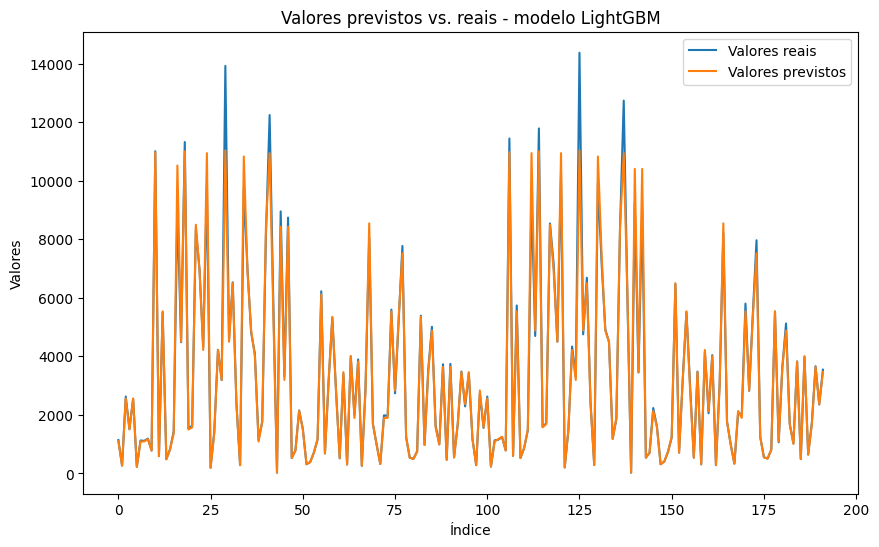

In [79]:
plt.figure(figsize=(10,6))
plt.plot(y_teste.values, label='Valores reais')
plt.plot(y_pred, label='Valores previstos')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores previstos vs. reais - modelo LightGBM')
plt.legend()

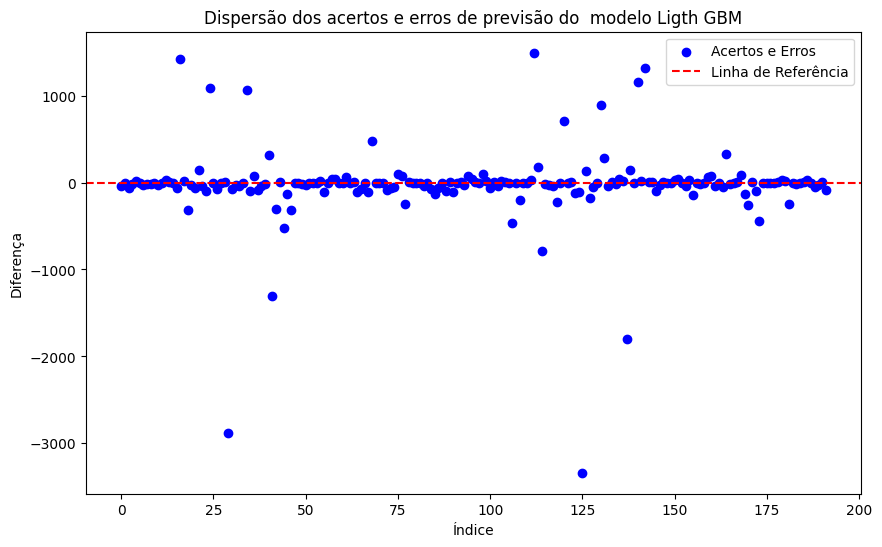

In [80]:
X_teste = pd.DataFrame(X_teste)
y_pred = pd.DataFrame(y_pred, columns=['previsao'])
X_teste = X_teste.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

resultado_lgb = pd.concat([X_teste, y_pred], axis=1)

resultado_lgb['previsao'] = resultado_lgb['previsao'].round(4)
resultado_lgb['diferenca'] = resultado_lgb['previsao'] - resultado_lgb['MAT_CRECHE']

plt.figure(figsize=(10, 6))
plt.scatter(range(len(resultado_lgb)), resultado_lgb["diferenca"], c='b', label="Acertos e Erros")
plt.axhline(0, color='r', linestyle='--', label="Linha de Referência")
plt.xlabel("Índice")
plt.ylabel("Diferença")
plt.title("Dispersão dos acertos e erros de previsão do  modelo Ligth GBM")
plt.legend()
plt.show()

### Random Forest Regressor

In [81]:
# Criar um dicionário com a ordem alfabética decrescente e os valores correspondentes
valores_codificados = {valor: i for i, valor in enumerate(sorted(df['DISTRITO'].unique(), reverse=True))}

# Aplicar a codificação à coluna 'MAT_CRECHE'
df['DIST_ENCODED'] = df['DISTRITO'].map(valores_codificados)

In [82]:
df_rf = df.loc[:,['DATA','MES','ANO','DISTRITO','DIST_ENCODED', 'MAT_CRECHE']]
df_rf['DATA'] = pd.to_datetime(df_rf['DATA'])

treino_rf = df_rf.loc[df_rf['DATA'] <= data_corte, :]
teste_rf = df_rf.loc[df_rf['DATA'] > data_corte, :]
cols_nao_usadas_rf = ['DATA', 'MES','DISTRITO']

X_treino_rf = treino_rf.loc[:, ~treino_rf.columns.isin(cols_nao_usadas_rf)]
y_treino_rf = treino_rf[['MAT_CRECHE']]

X_teste_rf = teste_rf.loc[:, ~teste_rf.columns.isin(cols_nao_usadas_rf)]
y_teste_rf = teste_rf[['MAT_CRECHE']]

modelo_rf = RandomForestRegressor()
modelo_rf.fit(X_treino_rf, y_treino_rf)
y_pred_rf = modelo_rf.predict(X_teste_rf)

C:\Users\letic\AppData\Local\Temp\ipykernel_9864\396694129.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_treino_rf, y_treino_rf)


In [83]:
rmse_rf = mean_squared_error(y_teste_rf, y_pred_rf, squared=False)
mape_rf = mean_absolute_percentage_error(y_teste_rf, y_pred_rf)
mae_rf = mean_absolute_error(y_teste_rf, y_pred_rf)
r2_rf = r2_score(y_teste_rf, y_pred_rf)

print("RMSE RF: ", rmse_rf)
print("MAPE RF: ", mape_rf)
print("MAE RF: ", mae_rf)
print("R2 RF: ", r2_rf)

RMSE RF:  78.18369314606682
MAPE RF:  0.005646671491588599
MAE RF:  28.26843749999999
R2 RF:  0.9994067861393889


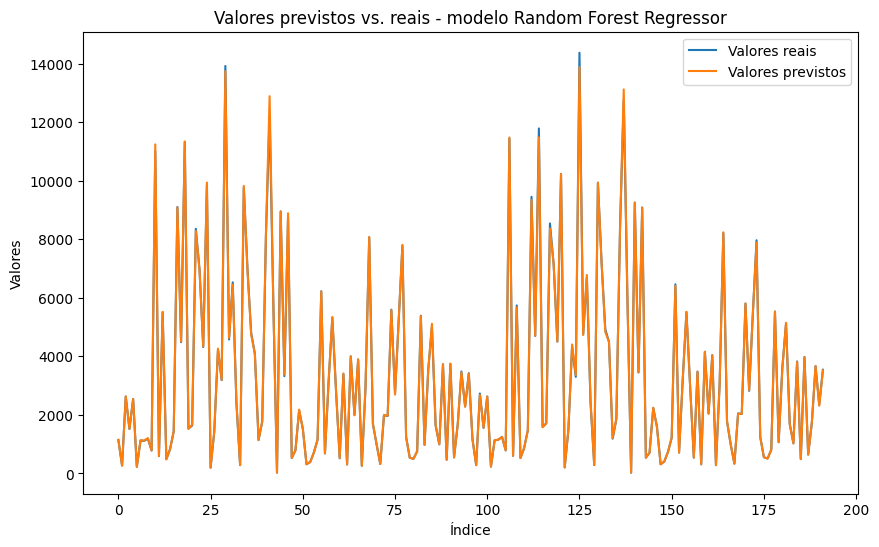

In [84]:
plt.figure(figsize=(10,6))
plt.plot(y_teste_rf.values, label='Valores reais')
plt.plot(y_pred_rf, label='Valores previstos')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores previstos vs. reais - modelo Random Forest Regressor')
plt.legend()

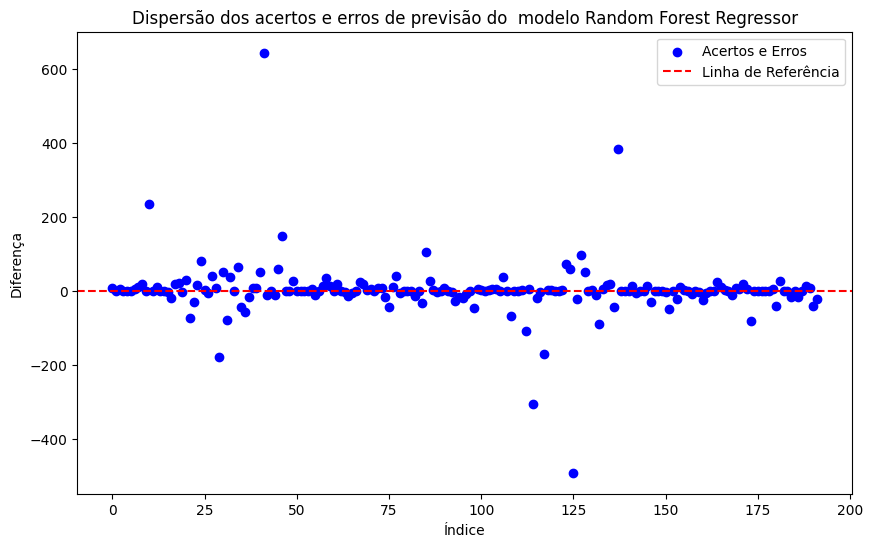

In [85]:
X_teste_rf = pd.DataFrame(X_teste_rf)
y_pred_rf = pd.DataFrame(y_pred_rf, columns=['previsao'])
X_teste_rf = X_teste_rf.reset_index(drop=True)
y_pred_rf = y_pred_rf.reset_index(drop=True)

resultado_rf = pd.concat([X_teste_rf, y_pred_rf], axis=1)

resultado_rf['previsao'] = resultado_rf['previsao'].round(4)
resultado_rf['diferenca'] = resultado_rf['previsao'] - resultado_rf['MAT_CRECHE']

plt.figure(figsize=(10, 6))
plt.scatter(range(len(resultado_rf)), resultado_rf["diferenca"], c='b', label="Acertos e Erros")
plt.axhline(0, color='r', linestyle='--', label="Linha de Referência")
plt.xlabel("Índice")
plt.ylabel("Diferença")
plt.title("Dispersão dos acertos e erros de previsão do  modelo Random Forest Regressor")
plt.legend()
plt.show()

### Modelagem considerando o agrupamento dos dados por ano

In [63]:
df_mat_creche.head()

,DATA,MAT_CRECHE
data_first_day,,
2006-06-01,2006-06,35467
2006-09-01,2006-09,33901
2006-12-01,2006-12,33448
2007-03-01,2007-03,33215
2007-06-01,2007-06,28641


In [ ]:
df_rf_2 = df_novo
df_rf_2['DATA'] = pd.to_datetime(df_rf_2['DATA'])

treino_rf = df_rf_2.loc[df_rf_2['DATA'] <= data_corte, :]
teste_rf = df_rf_2.loc[df_rf_2['DATA'] > data_corte, :]
cols_nao_usadas_rf = ['DATA', 'MES','DISTRITO']

X_treino_rf = treino_rf.loc[:, ~treino_rf.columns.isin(cols_nao_usadas_rf)]
y_treino_rf = treino_rf[['MAT_CRECHE']]

X_teste_rf = teste_rf.loc[:, ~teste_rf.columns.isin(cols_nao_usadas_rf)]
y_teste_rf = teste_rf[['MAT_CRECHE']]

modelo_rf = RandomForestRegressor()
modelo_rf.fit(X_treino_rf, y_treino_rf)
y_pred_rf = modelo_rf.predict(X_teste_rf)

rmse_rf = mean_squared_error(y_teste_rf, y_pred_rf, squared=False)
mape_rf = mean_absolute_percentage_error(y_teste_rf, y_pred_rf)
mae_rf = mean_absolute_error(y_teste_rf, y_pred_rf)
r2_rf = r2_score(y_teste_rf, y_pred_rf)

print("RMSE RF: ", rmse_rf)
print("MAPE RF: ", mape_rf)
print("MAE RF: ", mae_rf)
print("R2 RF: ", r2_rf)

## RF com boostrap

In [12]:
from sklearn.utils import resample

In [17]:
df = data.loc[:, ['DATA', 'ANO', 'MES', 'MES_NUM', 'DISTRITO', 'MAT_CRECHE']]
cols_nao_usadas = ['DATA', 'MES', 'DISTRITO']

valores_codificados = {valor: i for i, valor in enumerate(sorted(df['DISTRITO'].unique(), reverse=True))}
df['DIST_ENCODED'] = df['DISTRITO'].map(valores_codificados)

df_rfb = df.loc[:, ['DATA', 'MES', 'ANO', 'DISTRITO', 'DIST_ENCODED', 'MAT_CRECHE']]
df_rfb['DATA'] = pd.to_datetime(df_rfb['DATA'])

modelos = []
n_iter = 100

for i in range(n_iter):
    bootstrap_sample = df_rfb.groupby('DIST_ENCODED', group_keys=False).apply(lambda x: resample(x, replace=True))
    X_treino_bootstrap = bootstrap_sample.loc[:, ~bootstrap_sample.columns.isin(cols_nao_usadas)]
    y_treino_bootstrap = bootstrap_sample[['MAT_CRECHE']]
    X_teste_rf = df_rfb.loc[:, ~df_rfb.columns.isin(cols_nao_usadas)]
    y_teste_rf = df_rfb['MAT_CRECHE']

    modelo_rf = RandomForestRegressor()
    modelo_rf.fit(X_treino_bootstrap, y_treino_bootstrap)
    
    modelos.append(modelo_rf)

y_preds_rf = [modelo.predict(X_teste_rf) for modelo in modelos]
y_pred_rf_avg = np.mean(y_preds_rf, axis=0)

rmse_rf_avg = mean_squared_error(y_teste_rf, y_pred_rf_avg, squared=False)
mape_rf_avg = mean_absolute_percentage_error(y_teste_rf, y_pred_rf_avg)
mae_rf_avg = mean_absolute_error(y_teste_rf, y_pred_rf_avg)
r2_rf_avg = r2_score(y_teste_rf, y_pred_rf_avg)

print("RMSE RF (média):", rmse_rf_avg)
print("MAPE RF (média):", mape_rf_avg)
print("MAE RF (média):", mae_rf_avg)
print("R2 RF (média):", r2_rf_avg)

C:\Users\letic\AppData\Local\Temp\ipykernel_17076\2586407225.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_treino_bootstrap, y_treino_bootstrap)
C:\Users\letic\AppData\Local\Temp\ipykernel_17076\2586407225.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_treino_bootstrap, y_treino_bootstrap)
C:\Users\letic\AppData\Local\Temp\ipykernel_17076\2586407225.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_treino_bootstrap, y_treino_bootstrap)
C:\Users\letic\AppData\Local\Temp\ipykernel_17076\2586407225.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RMSE RF (média): 12.39898484925135
MAPE RF (média): 364192745601.8514
MAE RF (média): 0.8107362898284285
R2 RF (média): 0.999906091068949


### MERF

In [35]:
from merf.merf import MERF
from merf.viz import plot_merf_training_stats

In [70]:
data_corte = pd.to_datetime('2023-01')

valores_codificados = {valor: i for i, valor in enumerate(sorted(df['DISTRITO'].unique(), reverse=True))}
df['DIST_ENCODED'] = df['DISTRITO'].map(valores_codificados)
df['ANO'] = df['ANO'].astype(int)

df_rf = df.loc[:, ['DATA', 'MES','MES_NUM', 'ANO', 'DISTRITO', 'DIST_ENCODED', 'MAT_CRECHE']]
df_rf['DATA'] = pd.to_datetime(df_rf['DATA'])

treino = df_rf.loc[df_rf['DATA'] <= data_corte, :]
teste = df_rf.loc[df_rf['DATA'] > data_corte, :]
cols_nao_usadas = ['DATA', 'MES', 'DISTRITO']

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATA          6528 non-null   object
 1   ANO           6528 non-null   int32 
 2   MES           6528 non-null   object
 3   MES_NUM       6528 non-null   int64 
 4   DISTRITO      6528 non-null   object
 5   MAT_CRECHE    6528 non-null   int32 
 6   DIST_ENCODED  6528 non-null   int64 
dtypes: int32(2), int64(2), object(3)
memory usage: 306.1+ KB


In [71]:
X_treino = treino[['ANO','MES_NUM']]
Z_treino = treino[['DIST_ENCODED']]
clusters_treino = treino['DIST_ENCODED']
y_treino = treino['MAT_CRECHE']

X_teste = teste[['ANO','MES_NUM']]
Z_teste = teste[['DIST_ENCODED']]
clusters_teste = teste['DIST_ENCODED']
y_teste = teste['MAT_CRECHE']

In [72]:
mrf = MERF(max_iterations=5)
mrf.fit(X_treino, Z_treino, clusters_treino, y_treino)

INFO     [merf.py:307] Training GLL is 91458.72849665002 at iteration 1.
INFO     [merf.py:307] Training GLL is 91237.54155130043 at iteration 2.
INFO     [merf.py:307] Training GLL is 91154.92528039197 at iteration 3.
INFO     [merf.py:307] Training GLL is 91111.27188693387 at iteration 4.
INFO     [merf.py:307] Training GLL is 91086.26825468146 at iteration 5.


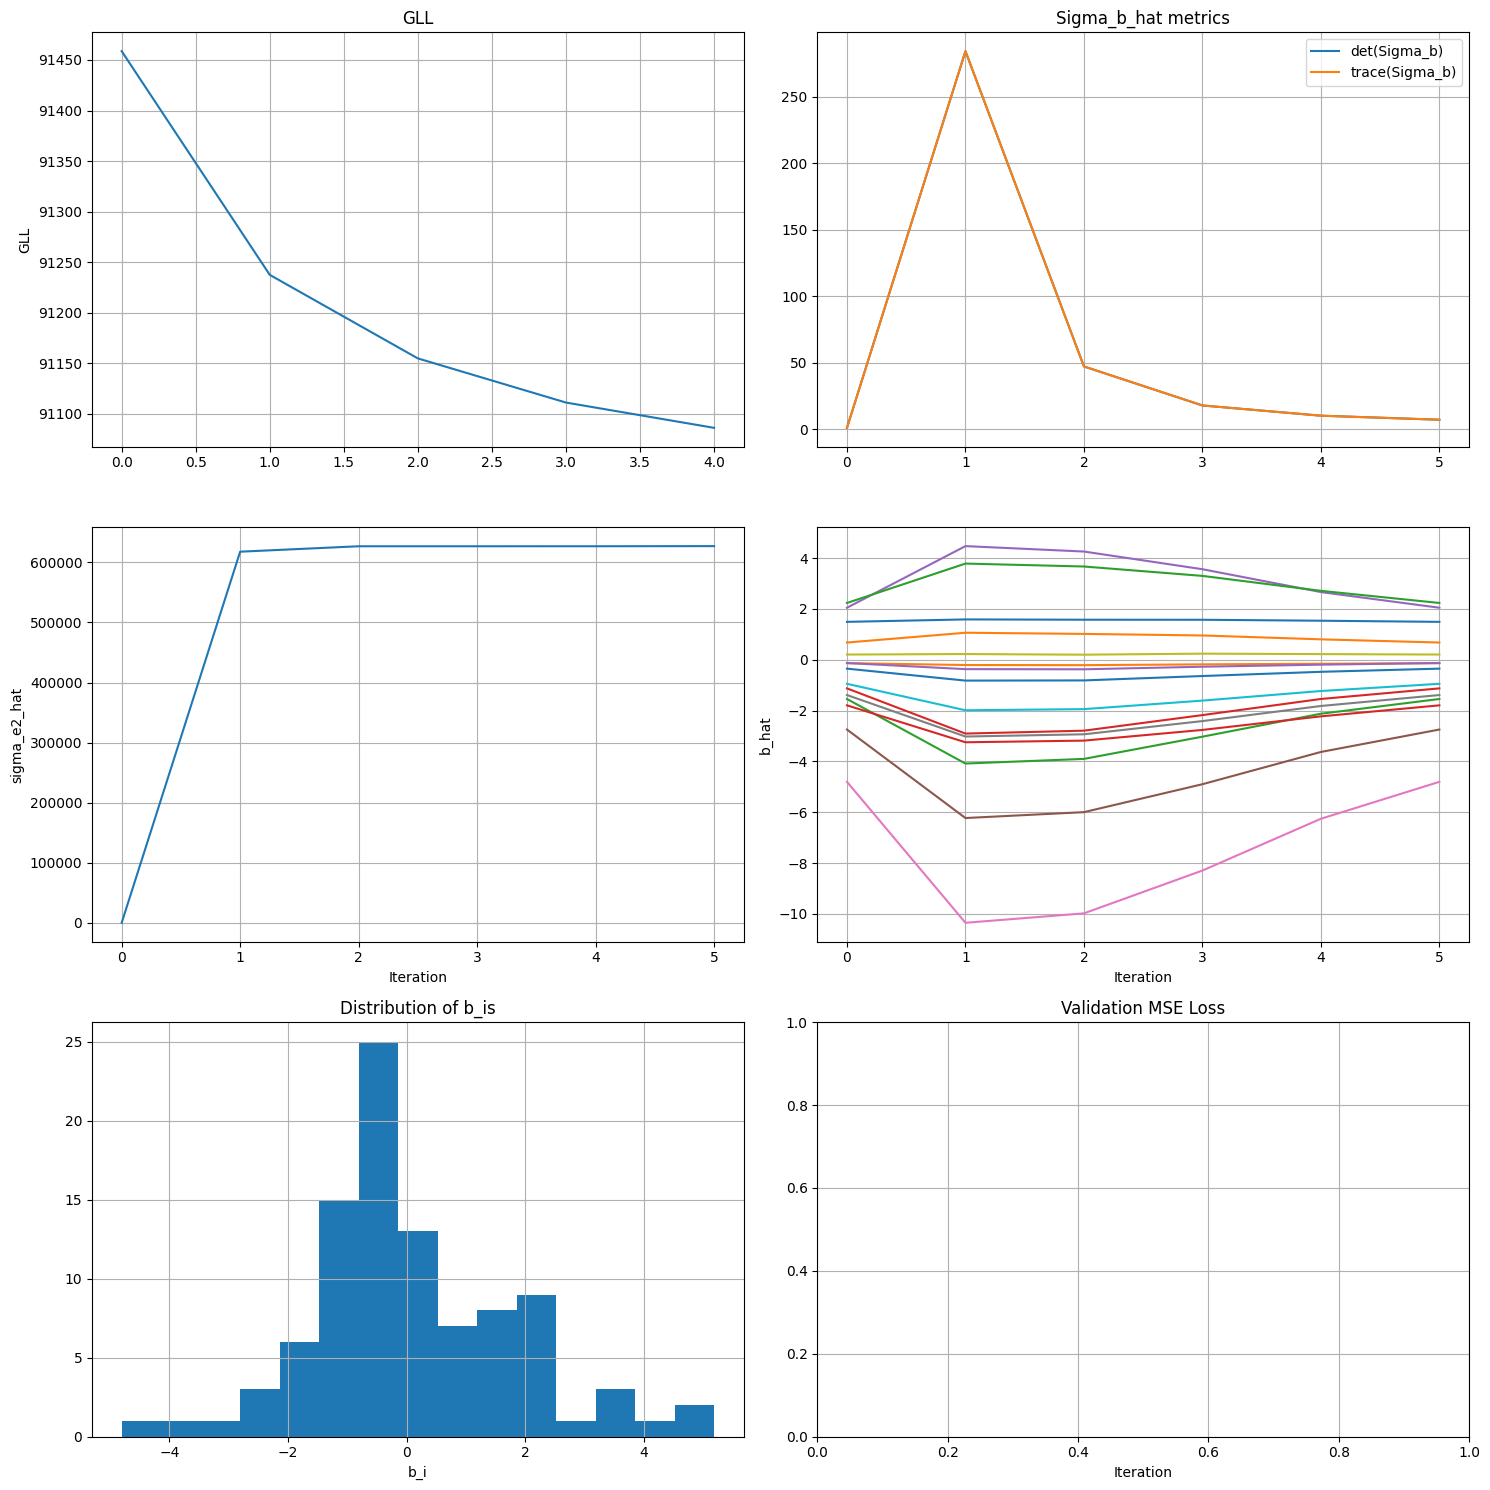

In [74]:
plot_merf_training_stats(mrf, num_clusters_to_plot=15)

In [83]:
X = df[['ANO','MES_NUM']]
Z = df[['DIST_ENCODED']]
clusters = df['DIST_ENCODED']
y = df['MAT_CRECHE']

y_hat= mrf.predict(X, Z, clusters)
y_hat

array([501.95214916, 347.75477545, 294.00348899, ..., 126.58330104,
       126.69365132, 126.84452299])

In [88]:
assert len(y_hat) == len(y)

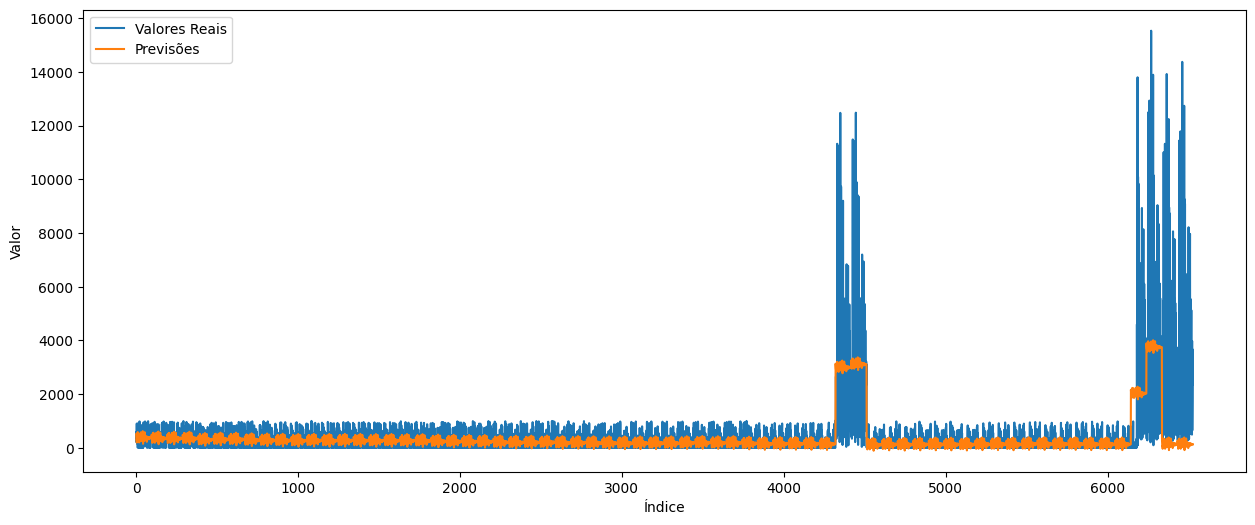

In [91]:
plt.figure(figsize=(15,6))
plt.plot(y, label='Valores Reais')
plt.plot(y_hat, label='Previsões')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATA          6528 non-null   object
 1   ANO           6528 non-null   int32 
 2   MES           6528 non-null   object
 3   MES_NUM       6528 non-null   int64 
 4   DISTRITO      6528 non-null   object
 5   MAT_CRECHE    6528 non-null   int32 
 6   DIST_ENCODED  6528 non-null   int64 
dtypes: int32(2), int64(2), object(3)
memory usage: 306.1+ KB


In [77]:
mrf_lgbm = MERF(lgbm, max_iterations=15)
mrf_lgbm.fit(X_treino, Z_treino, clusters_treino, y_treino)

INFO     [merf.py:307] Training GLL is 91459.2420049152 at iteration 1.
INFO     [merf.py:307] Training GLL is 91237.75763376804 at iteration 2.
INFO     [merf.py:307] Training GLL is 91154.96093658783 at iteration 3.
INFO     [merf.py:307] Training GLL is 91111.36170462883 at iteration 4.
INFO     [merf.py:307] Training GLL is 91085.94825024658 at iteration 5.
INFO     [merf.py:307] Training GLL is 91069.59339963696 at iteration 6.
INFO     [merf.py:307] Training GLL is 91058.2199546205 at iteration 7.
INFO     [merf.py:307] Training GLL is 91049.8540748146 at iteration 8.
INFO     [merf.py:307] Training GLL is 91043.45475751071 at iteration 9.
INFO     [merf.py:307] Training GLL is 91038.42264205981 at iteration 10.
INFO     [merf.py:307] Training GLL is 91034.38496466634 at iteration 11.
INFO     [merf.py:307] Training GLL is 91031.09543088854 at iteration 12.
INFO     [merf.py:307] Training GLL is 91028.3835533868 at iteration 13.
INFO     [merf.py:307] Training GLL is 91026.126903

In [81]:
# With validation loss
mrf_lgbm = MERF(lgbm, max_iterations=15)
mrf_lgbm.fit(X_treino, Z_treino, clusters_treino, y_treino, X_val, Z_val, clusters_val, y_val)
plot_merf_training_stats(mrf_lgbm, num_clusters_to_plot=10)

NameError: name 'X_val' is not defined

In [86]:
data['DATA'] = pd.to_datetime(data['DATA'])
data.set_index('DATA', inplace=True)

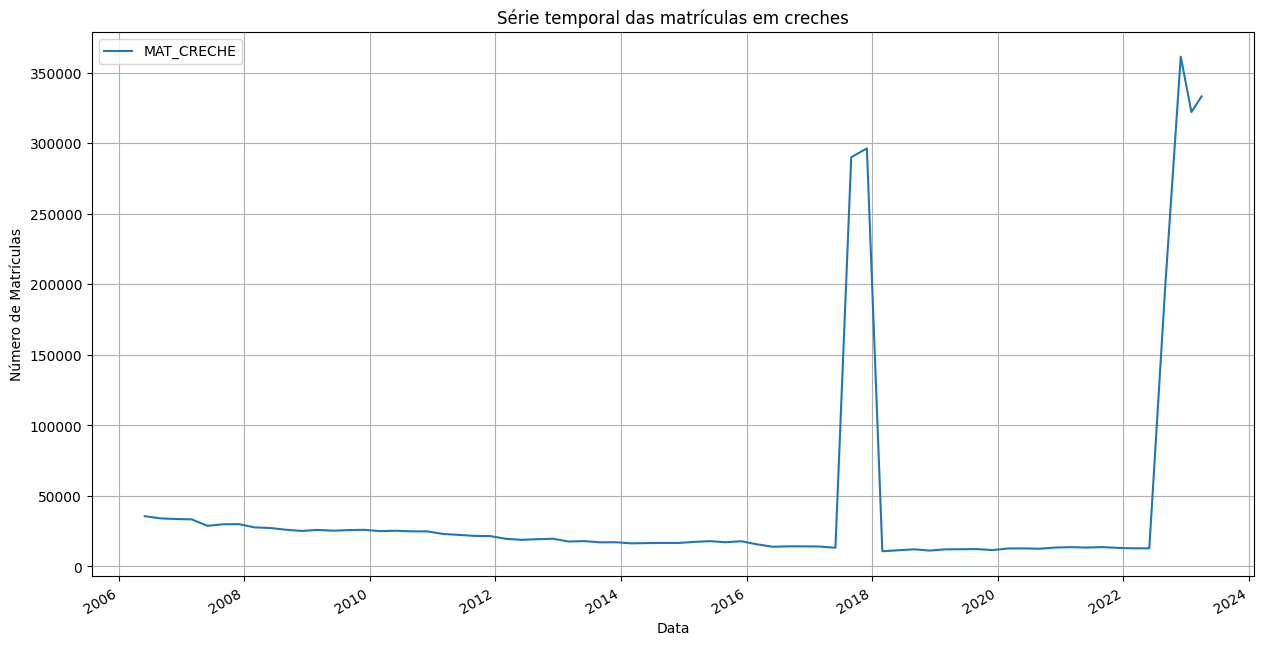

In [91]:
matriculas = df_mat_creche['MAT_CRECHE']
matriculas.plot(figsize=(15,8))
plt.xlabel('Data')
plt.ylabel('Número de Matrículas')
plt.title('Série temporal das matrículas em creches')
plt.legend()
plt.grid(True)